## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

- Since a game of tictactoe lasts for only 4-5 rounds, a step decay function would be a better choice as compared to exponential decay. 
- In the below epsilon_greedy method, the step_count and threshold (z) are passed. 
- If the step_count is greater than z, exploitation is preferred else the agent explores

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, step_count, z):
    if step_count > z:
        #Exploitation: this gets the action corresponding to max q-value of current state
        q_state = Q_state(state)
        action = max(Q_dict[q_state],key=Q_dict[q_state].get)
    else:
        #Exploration: randomly choosing and action
        action = random.choice(valid_actions(state))

    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x', (5,9)), \
                       ('x-x-x-x-x-x-x-6-1', (0,3)), \
                       ('4-x-x-x-x-x-x-x-7', (4,1)), \
                       ('x-x-x-x-x-x-x-8-5', (4,9))]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [11]:
EPISODES = 30000
LR = 0.1
GAMMA = 0.91
DEBUG = False

### Q-update loop ---write your code here

In [12]:
def run_agent(z, episodes=EPISODES, lr=LR, gamma=GAMMA, debug=DEBUG, env=TicTacToe()):
    start_time = time.time()
    summary = {10:0, -10:0, 0:0}
    total_steps = 0

    for episode in range(episodes):
        ##### Start writing your code from the next line
        env = TicTacToe()

        curr_state = env.state
        add_to_dict(curr_state)

        step_count = 0
        total_reward = 0
        is_terminated = False

        if debug:
            print()
            print('episode ', episode)
            print(str(curr_state[0]).replace('nan','x'), str(curr_state[1]).replace('nan','x'), str(curr_state[2]).replace('nan','x'))
            print(str(curr_state[3]).replace('nan','x'), str(curr_state[4]).replace('nan','x'), str(curr_state[5]).replace('nan','x'))
            print(str(curr_state[6]).replace('nan','x'), str(curr_state[7]).replace('nan','x'), str(curr_state[8]).replace('nan','x'))
            print()

        while is_terminated == False:
            curr_action = epsilon_greedy(curr_state, step_count, z)
            next_state, reward, is_terminated = env.step(curr_state, curr_action)
            add_to_dict(next_state)

            # UPDATE RULE
            next_q_state = Q_state(next_state)
            curr_q_state = Q_state(curr_state)
            if len(Q_dict[next_q_state]) > 0:
                max_next = max(Q_dict[next_q_state],key=Q_dict[next_q_state].get)   #this gets the action corresponding to max q-value of next state
                Q_dict[curr_q_state][curr_action] += lr * ((reward + (gamma*(Q_dict[next_q_state][max_next]))) - Q_dict[curr_q_state][curr_action]) 

            curr_state = next_state
            total_reward += reward
            step_count = step_count + 1

            if debug:
                print(str(curr_state[0]).replace('nan','x'), str(curr_state[1]).replace('nan','x'), str(curr_state[2]).replace('nan','x'))
                print(str(curr_state[3]).replace('nan','x'), str(curr_state[4]).replace('nan','x'), str(curr_state[5]).replace('nan','x'))
                print(str(curr_state[6]).replace('nan','x'), str(curr_state[7]).replace('nan','x'), str(curr_state[8]).replace('nan','x'))
                print()

        summary[reward] = summary[reward] + 1
        total_steps = total_steps + step_count
        if debug:
            print('result: ', reward)

        save_tracking_states()

    elapsed_time = time.time() - start_time
    save_obj(States_track,'States_tracked')   
    save_obj(Q_dict,'Policy')
    
    return elapsed_time, summary, round(total_steps/episodes, 2)

In [13]:
z_df = {'z':[], 'run_time':[], 'win_count':[], 'loss_count':[], 'tie_count':[], 'average_steps_per_episode':[]}
env = TicTacToe()
for z in range(-1,6):
    Q_dict = collections.defaultdict(dict)
    States_track = collections.defaultdict(dict)
    run_time, reward_summary, average_steps_per_episode = run_agent(z, episodes=30000, env=env)
    z_df['z'].append(z)
    z_df['run_time'].append(run_time)
    z_df['win_count'].append(reward_summary[10])
    z_df['loss_count'].append(reward_summary[-10])
    z_df['tie_count'].append(reward_summary[0])
    z_df['average_steps_per_episode'].append(average_steps_per_episode)
    print(z, ' completed')
    
z_df

-1  completed
0  completed
1  completed
2  completed
3  completed
4  completed
5  completed


{'z': [-1, 0, 1, 2, 3, 4, 5],
 'run_time': [24.87272882461548,
  24.86929202079773,
  28.465320110321045,
  25.430346965789795,
  25.846315145492554,
  33.029417991638184,
  35.8553409576416],
 'win_count': [8153, 8112, 7960, 7542, 7430, 7344, 7376],
 'loss_count': [8134, 8101, 8222, 8485, 8543, 8644, 8537],
 'tie_count': [13713, 13787, 13818, 13973, 14027, 14012, 14087],
 'average_steps_per_episode': [4.37, 4.37, 4.37, 4.37, 4.38, 4.38, 4.38]}

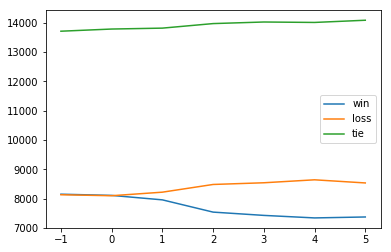

In [14]:
xaxis = np.asarray(z_df['z'])
plt.plot(xaxis, np.asarray(z_df['win_count']))
plt.plot(xaxis, np.asarray(z_df['loss_count']))
plt.plot(xaxis, np.asarray(z_df['tie_count']))
plt.gca().legend(('win','loss','tie'))
plt.show()

- On running the q-update loop with all possible values of threshold, the value of 0 gives best result.
- This implies that for the first move, the agent will explore the choices (choose a move randomly) and for subsequent moves, it will try to take an action greedily

In [15]:
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
initialise_tracking_states()
env = TicTacToe()
run_time, reward_summary, average_steps_per_episode = run_agent(z=0, episodes=100000, env=env)
print('total run time (seconds): ', run_time)
print('reward summary: ', reward_summary)
print('average steps per episode: ', average_steps_per_episode)

total run time (seconds):  86.25597596168518
reward summary:  {10: 27930, -10: 26651, 0: 45419}
average steps per episode:  4.35


#### Check the Q-dictionary

In [16]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.1725724903562997,
              (0, 3): -1.1768625784521196,
              (0, 5): -1.1697590756512697,
              (0, 7): -1.1760255827387671,
              (0, 9): -1.1602943737824583,
              (1, 1): -1.1721843604270905,
              (1, 3): -1.1746850008991396,
              (1, 5): -1.1718723108000115,
              (1, 7): -1.1773109889621942,
              (1, 9): -1.1737517552000205,
              (2, 1): -1.177345528967236,
              (2, 3): -1.18522350728302,
              (2, 5): -1.1730745166933905,
              (2, 7): -1.1760288826619516,
              (2, 9): -1.170658889028393,
              (3, 1): -1.1714534975772106,
              (3, 3): -1.1885451629583188,
              (3, 5): -1.1985176844857683,
              (3, 7): -1.159426949472188,
              (3, 9): -1.175859010655126,
              (4, 1): -1.1987386976329615,
              (4, 3): -1.1820220961541232,
              (4, 5):

In [17]:
len(Q_dict)

284946

In [18]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
# Q_dict['x-x-x-x-x-x-x-x-x']
sorted(Q_dict['x-x-x-x-x-x-x-x-x'].items(), key=lambda kv: kv[1], reverse=True)[:10]

[((3, 7), -1.159426949472188),
 ((0, 9), -1.1602943737824583),
 ((7, 5), -1.1646540132442522),
 ((0, 5), -1.1697590756512697),
 ((2, 9), -1.170658889028393),
 ((3, 1), -1.1714534975772106),
 ((1, 5), -1.1718723108000115),
 ((1, 1), -1.1721843604270905),
 ((0, 1), -1.1725724903562997),
 ((6, 5), -1.1726457091902591)]

In [19]:
sorted(Q_dict['x-x-6-x-x-x-x-x-7'].items(), key=lambda kv: kv[1], reverse=True)[:10]

[((4, 5), -0.19),
 ((4, 9), -0.19),
 ((5, 1), -0.19),
 ((5, 3), -0.19),
 ((5, 5), -0.19),
 ((6, 1), -0.19),
 ((6, 3), -0.19),
 ((6, 5), -0.19),
 ((6, 9), -0.19),
 ((7, 3), -0.19)]

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [20]:
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

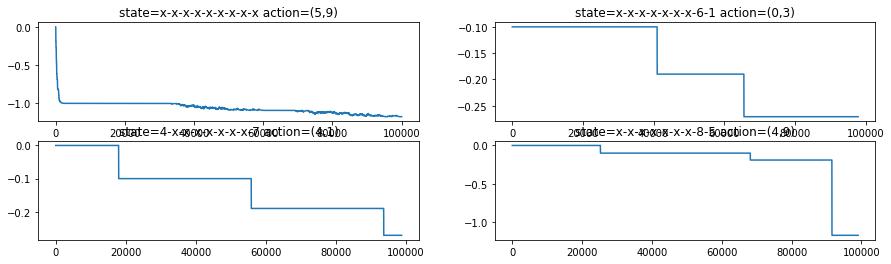

In [21]:
plt.figure(0, figsize=(15,4))

plt.subplot(221)
plt.title('state=x-x-x-x-x-x-x-x-x action=(5,9)')
plt.plot(np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(5, 9)]))), \
         np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(5, 9)]))

plt.subplot(222)
plt.title('state=x-x-x-x-x-x-x-6-1 action=(0,3)')
plt.plot(np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-6-1'][(0, 3)]))), \
         np.asarray(States_track['x-x-x-x-x-x-x-6-1'][(0, 3)]))

plt.subplot(223)
plt.title('state=4-x-x-x-x-x-x-x-7 action=(4,1)')
plt.plot(np.asarray(range(0, len(States_track['4-x-x-x-x-x-x-x-7'][(4, 1)]))), \
         np.asarray(States_track['4-x-x-x-x-x-x-x-7'][(4, 1)]))

plt.subplot(224)
plt.title('state=x-x-x-x-x-x-x-8-5 action=(4,9)')
plt.plot(np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-8-5'][(4, 9)]))), \
         np.asarray(States_track['x-x-x-x-x-x-x-8-5'][(4, 9)]))

plt.show()